In [1]:
import tensorflow as tf
print(tf.__version__)  # 应输出版本号无报错

2.19.0


In [7]:
#训练模型代码
import os
import pickle
import jieba
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# ====================
# 参数设置
# ====================
DATA_PATH = 'D:/all.csv'
MODEL_PATH = 'D:/作业/2024————2025——2/python/第三周/sentiment_model.h5'
TOKENIZER_PATH = 'D:/作业/2024————2025——2/python/第三周/tokenizer.pkl'
MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 50
LSTM_UNITS = 128
BATCH_SIZE = 64
EPOCHS = 5
TEST_SIZE = 0.2
RANDOM_STATE = 42

# ====================
# 文本预处理
# ====================
def preprocess_text(text):
    return ' '.join(jieba.lcut(str(text)))

def load_and_preprocess_data(filepath):
    print("加载数据中...")
    data = pd.read_csv(filepath, encoding='gbk')
    texts = data['evaluation'].astype(str)
    labels = pd.get_dummies(data['label']).values
    processed_texts = [preprocess_text(t) for t in texts]
    
    print("\n示例预处理结果：")
    for i in range(min(5, len(processed_texts))):
        print(f"{i+1}: {processed_texts[i][:50]}...")
    
    return processed_texts, labels

# ====================
# 文本向量化
# ====================
def vectorize_texts(texts, max_len=MAX_SEQUENCE_LENGTH):
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len)

    print(f"\n词汇表大小：{len(tokenizer.word_index)+1}")
    print("前5条向量化结果：")
    print(padded[:5])

    return padded, tokenizer

# ====================
# 模型构建
# ====================
def build_lstm_model(vocab_size, embedding_dim, input_len, lstm_units, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(units=num_classes, activation='softmax'))  # 使用真实类别数
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.summary()
    return model

# ====================
# 训练流程
# ====================
def train_model():
    texts, labels = load_and_preprocess_data(DATA_PATH)
    X, tokenizer = vectorize_texts(texts)
    y = labels

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    vocab_size = len(tokenizer.word_index) + 1
    num_classes = y.shape[1]

    model = build_lstm_model(
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        input_len=X.shape[1],
        lstm_units=LSTM_UNITS,
        num_classes=num_classes
    )

    print("\n开始训练模型...")
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=2)

    print("\n保存模型与 tokenizer...")
    model.save(MODEL_PATH)
    with open(TOKENIZER_PATH, 'wb') as f:
        pickle.dump(tokenizer, f)

    print("\n评估模型...")
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"✅ 验证集准确率：{acc * 100:.2f}%")
    
    # 返回 history 以便后续使用
    return history

# ====================
# 主程序入口
# ====================
if __name__ == '__main__':
    try:
        history = train_model()  # 保存返回的 history
    except Exception as e:
        print("❌ 发生错误：", e)


加载数据中...

示例预处理结果：
1: [ 呵呵 ]   / / @ 厨缘 觅友 : [ good ] [ good ] [ good ] ...
2: 这锅 到 你家 把 作用 最大化 啦 [ 鼓掌 ] [ 鼓掌 ] [ 鼓掌 ]...
3: 找妹 哦 [ 爱 你 ] [ 哈哈 ] [ 嘻嘻 ] [ 呵呵 ]   / / @ 贺宁 _ :  ...
4: 父亲节 送 了 老爸 一块 菜地 ， 这个 主意 不错 吧 [ 兔子 ] ， 现实 版 开心 农场 ...
5: [ 哈哈 ] 全国 土地利用 数据 的 制图 综合 。 随着 数据库 的 兴起 ， 电子地图 的 普...

词汇表大小：197208
前5条向量化结果：
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  165  147  147  147  117  117  117   19   19   19  530 2299 2299
   530    7    1 2552    5  667    1   18  182   47    6    2 4218   44
  4968 2588  649 4784  313   10  946    3 3303   23    3  548  165 1886
   465  175]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 

C:\Users\86134\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


开始训练模型...
Epoch 1/5
1500/1500 - 34440s - 23s/step - accuracy: 0.9654 - loss: 0.1126 - val_accuracy: 0.9817 - val_loss: 0.0642
Epoch 2/5
1500/1500 - 288s - 192ms/step - accuracy: 0.9803 - loss: 0.0598 - val_accuracy: 0.9819 - val_loss: 0.0461
Epoch 3/5
1500/1500 - 234s - 156ms/step - accuracy: 0.9811 - loss: 0.0470 - val_accuracy: 0.9813 - val_loss: 0.0464
Epoch 4/5
1500/1500 - 237s - 158ms/step - accuracy: 0.9811 - loss: 0.0454 - val_accuracy: 0.9823 - val_loss: 0.0506
Epoch 5/5
1500/1500 - 257s - 171ms/step - accuracy: 0.9809 - loss: 0.0451 - val_accuracy: 0.9823 - val_loss: 0.0475



保存模型与 tokenizer...

评估模型...
✅ 验证集准确率：98.23%


In [26]:
import pandas as pd
import numpy as np
import jieba
import re
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ========== 配置 ========== 
MODEL_PATH = 'D:/作业/2024————2025——2/python/第三周/sentiment_model.h5'
TOKENIZER_PATH = 'D:/作业/2024————2025——2/python/第三周/tokenizer.pkl'
CSV_PATH = 'D:/weibo_comments_cleaned2.csv'  # 原始数据路径
OUTPUT_PATH = 'D:/weibo_predictions.csv'  # 预测结果保存路径
MAX_SEQUENCE_LENGTH = 100  # 必须与训练时一致
MAX_NUM_WORDS = 5000  # 必须与训练时一致

# ========== 加载模型与Tokenizer ========== 
model = load_model(MODEL_PATH)
with open(TOKENIZER_PATH, 'rb') as f:
    tokenizer = pickle.load(f)

# ========== 数据清理和预处理 ========== 
def preprocess_text(text):
    """文本预处理，包括分词和去除无关字符"""
    # 去除无关字符和表情符号（简化示例）
    text = re.sub(r'[^\w\s]', '', text)  # 仅保留字母、数字和空格（可根据需要调整）
    # 文本标准化：转换为小写并去除多余空格
    text = text.lower().strip()
    # 分词处理
    return ' '.join(jieba.lcut(text))

def clean_and_preprocess_data(csv_path):
    """加载CSV文件，进行数据清理和预处理"""
    df = pd.read_csv(csv_path)
    
    # 去除重复评论
    df.drop_duplicates(subset=['评论内容'], inplace=True)
    
    # 应用文本预处理函数
    df['评论内容'] = df['评论内容'].astype(str).apply(preprocess_text)
    
    return df

# ========== 加载并预处理数据 ========== 
df = clean_and_preprocess_data(CSV_PATH)

# ========== 文本向量化 ========== 
sequences = tokenizer.texts_to_sequences(df['评论内容'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# ========== 模型预测 ========== 
predictions = model.predict(padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)

# ========== 标签映射 ========== 
df['预测标签'] = predicted_labels
df['情感倾向'] = df['预测标签'].map({0: '负面', 1: '正面'})  # 确保标签一致

# ========== 保存预测结果 ========== 
df.to_csv(OUTPUT_PATH, index=False, encoding='utf-8-sig')
print("✅ 预测完成，结果已保存至：", OUTPUT_PATH)
print(df[['评论内容', '情感倾向']].head())

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step
✅ 预测完成，结果已保存至： D:/weibo_predictions.csv
                                                评论内容 情感倾向
0                                祝贺 天问 二号 发射 圆满成功 威武   正面
1  我国 开启 小行星 探测 与 采样 返回 之旅   祝贺 天问 二号 发射 圆满成功 666...   正面
2  我 就 说 怎么 一直 睡不着 冥冥之中 挂念 着 天问 二号 啊 这刷 下 手机 就 收到...   负面
3                                        为 祖国 航天 赞赞赞   负面
4         一 觉醒 来 的 好消息 祝 祖国 航天事业 蒸蒸日上 祝 祖国 繁荣昌盛 送 花花   负面


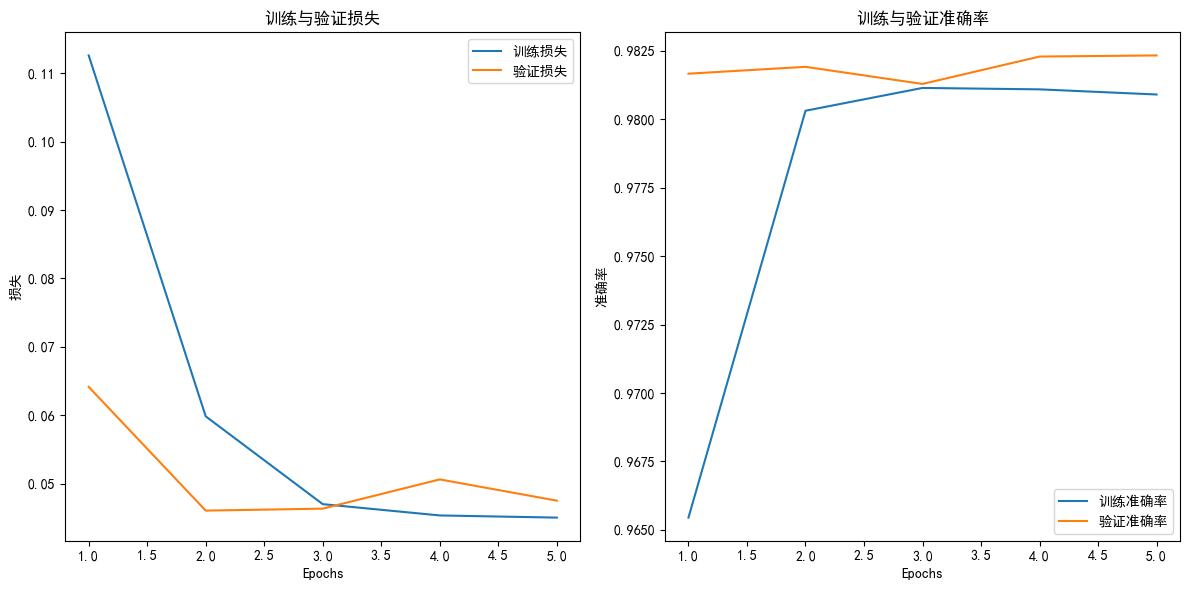

In [8]:
#训练与验证损失/准确率图
import matplotlib.pyplot as plt

# 假设你已经有了训练历史 history
# history = model.fit(...)  # 这段代码已经存在你的训练过程中


# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


def plot_training_history(history):
    """绘制训练和验证的损失和准确率曲线"""
    
    # 获取训练和验证损失和准确率
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    # 创建画布
    plt.figure(figsize=(12, 6))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='训练损失')
    plt.plot(epochs, val_loss, label='验证损失')
    plt.title('训练与验证损失')
    plt.xlabel('Epochs')
    plt.ylabel('损失')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='训练准确率')
    plt.plot(epochs, val_acc, label='验证准确率')
    plt.title('训练与验证准确率')
    plt.xlabel('Epochs')
    plt.ylabel('准确率')
    plt.legend()

    # 显示图表
    plt.tight_layout()
    plt.show()

# 调用函数绘制训练历史图
plot_training_history(history)



In [9]:
#混淆矩阵
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 对验证集进行预测
y_val_pred = model.predict(X_val)
y_val_labels = np.argmax(y_val, axis=1)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# 混淆矩阵
cm = confusion_matrix(y_val_labels, y_val_pred_labels)

# 可视化
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['负面', '正面'])
disp.plot(cmap=plt.cm.Blues)
plt.title('验证集混淆矩阵')
plt.show()


NameError: name 'model' is not defined

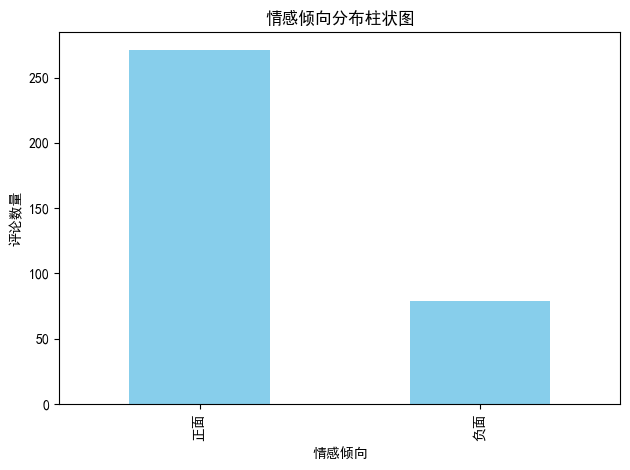

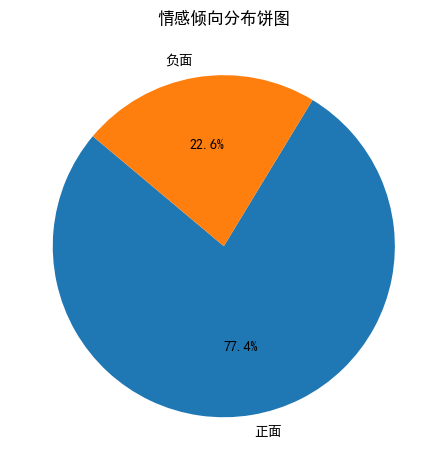

In [29]:
#情感标签分布图
import pandas as pd
import matplotlib.pyplot as plt

# 读取预测结果数据
df = pd.read_csv("D:/weibo_predictions.csv", encoding='utf-8-sig')

# 计算情感标签分布
emotion_counts = df['情感倾向'].value_counts()

# 柱状图
emotion_counts.plot(kind='bar', color='skyblue')
plt.title("情感倾向分布柱状图")
plt.xlabel("情感倾向")
plt.ylabel("评论数量")
plt.tight_layout()
plt.show()

# 饼图
emotion_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("情感倾向分布饼图")
plt.ylabel("")  # 去掉 y 轴标签
plt.tight_layout()
plt.show()


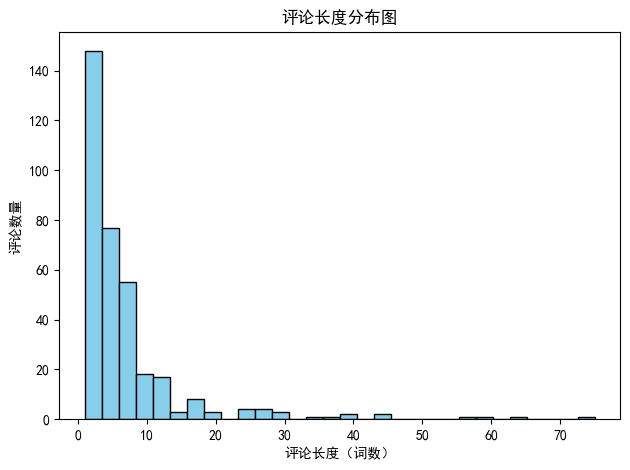

In [31]:
#评论长度分布图
import matplotlib.pyplot as plt

# 评论长度分布图
# 计算每条评论的词数
# 确保评论内容为字符串类型，并处理缺失值
df['评论内容'] = df['评论内容'].astype(str).fillna('')  # 将所有内容转换为字符串，并填充缺失值为空字符串
df['评论长度'] = df['评论内容'].apply(lambda x: len(x.split()))

# 绘制评论长度分布图（直方图）
plt.hist(df['评论长度'], bins=30, color='skyblue', edgecolor='black')
plt.title("评论长度分布图")
plt.xlabel("评论长度（词数）")
plt.ylabel("评论数量")
plt.tight_layout()
plt.show()


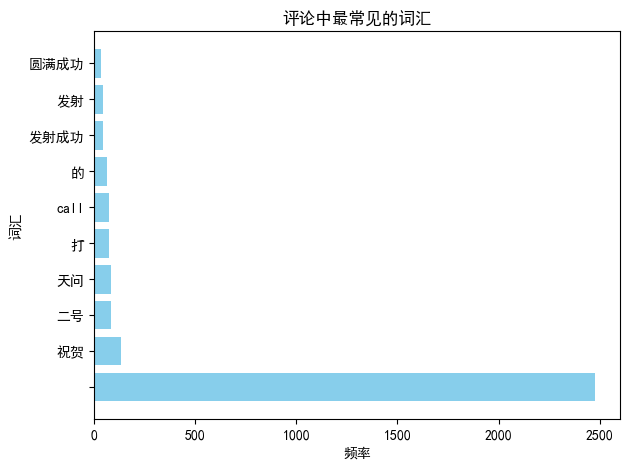

In [32]:
#词汇频率分布图
from collections import Counter
import jieba

# 分词
all_text = " ".join(df['评论内容'])
words = jieba.cut(all_text)
word_counts = Counter(words)

# 获取前10个高频词
common_words = word_counts.most_common(10)
word, count = zip(*common_words)

# 绘制词汇频率分布图（条形图）
plt.barh(word, count, color='skyblue')
plt.title("评论中最常见的词汇")
plt.xlabel("频率")
plt.ylabel("词汇")
plt.tight_layout()
plt.show()


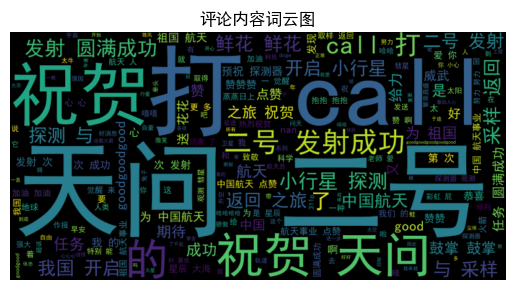

In [33]:
#词云图
from wordcloud import WordCloud

# 生成词云图
text = " ".join(jieba.cut(all_text))  # 使用结巴分词
wordcloud = WordCloud(font_path="simhei.ttf", width=800, height=400).generate(text)

# 绘制词云图
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("评论内容词云图")
plt.show()
